<a href="https://colab.research.google.com/github/reIkaros/jnotebooks/blob/main/NLP_complex/NLP_complex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Загрузка данных mos.ru, стопслов, данных с mapbox, размеченного датасета

In [ ]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1n1ax53On1A3B6EpFmGTms8YoofrE7NMy'  -O Mosru_dump_all_pages.txt
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1E0Vln-pzfbhLvwE9M8O-9e7I_XsQ_fHm'  -O distrs_strs.txt
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1TQd-UIyCf9MiDu8QWZjF7-d8VfHrmIlN'  -O Stopwords.txt
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1sdOdFQJOhCk7HlyCj64ygQ4xsJ_JXnbY'  -O train_len_labels.xlsx

--2021-05-04 11:44:06--  https://docs.google.com/uc?export=download&id=1n1ax53On1A3B6EpFmGTms8YoofrE7NMy
Resolving docs.google.com (docs.google.com)... 108.177.119.102, 108.177.119.139, 108.177.119.138, ...
Connecting to docs.google.com (docs.google.com)|108.177.119.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/h9lbbtm6ghhkfr79p7ud5lt99uvf36ad/1620128625000/03619448018617981983/*/1n1ax53On1A3B6EpFmGTms8YoofrE7NMy?e=download [following]
--2021-05-04 11:44:08--  https://doc-08-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/h9lbbtm6ghhkfr79p7ud5lt99uvf36ad/1620128625000/03619448018617981983/*/1n1ax53On1A3B6EpFmGTms8YoofrE7NMy?e=download
Resolving doc-08-ak-docs.googleusercontent.com (doc-08-ak-docs.googleusercontent.com)... 173.194.69.132, 2a00:1450:4013:c04::84
Connecting to doc-08-ak-docs.googleusercontent.com (doc-08-

# Первичная обработка данных

In [ ]:
!pip install pandas==1.1.5
%config Compiler.use_jedi = False

import pandas as pd
import numpy as np
import re

In [ ]:
colnames = ['theme','message', 'name', 'position', 'date']
frame = pd.read_csv('Mosru_dump_all_pages.txt',
                    delimiter="', '",
                    header=None,
                    engine='python',
                    encoding='utf-8',
                    names=colnames)

In [ ]:
frame['theme'] = frame['theme'].map(lambda x: x.lstrip("'"))
frame['date'] = frame['date'].map(lambda x: x.rstrip("'"))
frame["topics"] = frame['theme'].apply(lambda x: re.findall('«.*»', x)[0].replace('\\\\','').strip('«» '))

# Очистка содержимого сообщений и постановка слов в нормальную форму

In [ ]:
!pip install pymorphy2==0.9.1
!pip install -U pymorphy2-dicts-ru==2.4.417127.4579844
!pip install DAWG==0.8.0
import pymorphy2

morph = pymorphy2.MorphAnalyzer()

Requirement already up-to-date: pymorphy2-dicts-ru==2.4.417127.4579844 in /usr/local/lib/python3.7/dist-packages (2.4.417127.4579844)


In [ ]:
def clearing_words(mes):
    
    mes = mes.replace('\\n', ' ')
    mes = mes.replace('.', '. ')
    mes = mes.replace(',', ', ')
    
    txt = mes.split()
    
    txt_clear = []
    
    for t in txt:
        t = filter(str.isalpha, t)
        t = ''.join(t)
        if t:
            txt_clear.append(morph.parse(t)[0].normal_form)
        
    return txt_clear

In [ ]:
def load_stop_words():

    stopwords = []

    path_to_file = "Stopwords.txt"

    with open(path_to_file, "r", encoding="utf-8") as fl:

        for line in fl:

            stopwords.append(line.strip("\n"))

    return stopwords

In [ ]:
def cl_and_stop_words(s):
    res = clearing_words(s)
    res = [r for r in res if r not in stopwords]
    return res

In [ ]:
%%time

clear_messages = frame['message']

clear_messages = list(map(lambda x: clearing_words(x), clear_messages))

stopwords = load_stop_words()

clearest_messages = []

for mes in clear_messages:
    clearest_messages.append(list(filter(lambda x: x not in stopwords, mes)))

CPU times: user 43 s, sys: 311 ms, total: 43.3 s
Wall time: 43.4 s


# LDA Gensim (тематическое моделирование)

In [ ]:
!pip install gensim==4.0.1 python-Levenshtein==0.12.2
import gensim

In [ ]:
messages_LDA = [message for message in clearest_messages if len(message)>10]

dictionary = gensim.corpora.Dictionary(messages_LDA)

dictionary.filter_extremes(no_below=3)

corpus = [dictionary.doc2bow(message) for message in messages_LDA]

num_topics = 3
%time lda_model = gensim.models.LdaModel(corpus, num_topics=num_topics, \
                                         id2word=dictionary, \
                                         passes=4, alpha=[0.01]*num_topics, \
                                         eta=[0.01]*len(dictionary.keys()))

CPU times: user 24.9 s, sys: 172 ms, total: 25.1 s
Wall time: 25 s


## Визуализация LDA

In [ ]:
!pip install pyLDAvis==3.2.2
%matplotlib inline
import pyLDAvis
import pyLDAvis.gensim
vis = pyLDAvis.gensim.prepare(topic_model=lda_model, corpus=corpus, dictionary=dictionary)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


# Поиск в строках заголовков сообщений адресов и очистка результатов

In [ ]:
addresses = []

for address in frame['theme']:
    
    ref = re.findall(r"адресу\s?([^\}]*).\(", address)
    
    if not(ref):
        addresses.append(re.findall(r"адресу\s?([^\}]*)", address)[0])
    else:
        addresses.append(ref[0])

addresses = [address.replace(r'\\', '').lower() for address in addresses]

addr_uniq = list(np.unique([addr for addr in addresses if addr]))

## Очистка списка адресов от похожих значений

In [ ]:
!pip install fuzzywuzzy==0.18.0
!pip install tqdm==4.60.0
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from tqdm import tqdm

addr_uniqest = addr_uniq.copy()

for i in tqdm(range(len(addr_uniqest))):
    if addr_uniqest[i]:
        similarity = process.extract(addr_uniqest[i], addr_uniqest[i:i+20], limit=10, scorer=fuzz.ratio)
        
        for sim in similarity[1:]:
            if sim[1] > 90:
                addr_uniqest[addr_uniqest.index(sim[0])] = similarity[0][0]

100%|██████████| 29255/29255 [00:21<00:00, 1357.03it/s]


### Вставка значений в датафрейм

In [ ]:
addr_dict = dict(zip(addr_uniq, addr_uniqest))

In [ ]:
frame['address'] = pd.Series(addresses)
frame['address_un'] = frame['address'].map(addr_dict)
frame['address_un'].fillna('', inplace=True)

### Загрузка взятых с Mapbox данных

In [ ]:
'''
Данные были получены путём запросов к Mapbox.
Для запросов необходим токен.
Результаты запросов были обработаны и сохранены в файл distrs_strs.txt
'''
with open(r'distrs_strs.txt', 'r', encoding='utf-8') as f:
    addr_distrs = f.read().splitlines()

## Извлечение районов и запись в датафрейм

In [ ]:
def addr_distr_clearing(addr_distr):
    adlist = addr_distr.split(', ')
    if len(adlist)>3:
        dlist = adlist[3].split()
        if dlist[0] == 'округ':
            res = ' '.join(dlist[1:])
            return res
    else:
        return ''

In [ ]:
addr_distrs_clear = []

for ad in addr_distrs:
    res = addr_distr_clearing(ad)
    addr_distrs_clear.append(res)

addr_distrs_clear = list(map(lambda x: x if x else '', addr_distrs_clear))

In [ ]:
dist_dict = dict(zip(np.unique(addr_uniqest), addr_distrs_clear))

In [ ]:
frame['district'] = frame['address_un'].map(dist_dict)

# Извлечение времени

In [ ]:
# Потрясающе, что в 2021 нужно ставить русский язык отдельно для Линуха
!apt-get install language-pack-ru-base
!dpkg-reconfigure locales

Reading package lists... Done
Building dependency tree       
Reading state information... Done
language-pack-ru-base is already the newest version (1:18.04+20180712).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
Generating locales (this might take a while)...
  en_US.UTF-8... done
  ru_RU.UTF-8... done
  ru_UA.UTF-8... done
Generation complete.


In [ ]:
import datetime
import locale

'''
При возникновении ошибки с неподдерживаемой локалью, необходимо перезапустить ноутбук ещё раз,
Ubuntu не сразу подтягивает новую локаль в Python
'''
#locale.setlocale(locale.LC_ALL, 'ru') # из-под Шиндошс
locale.setlocale(locale.LC_ALL, 'ru_RU.utf8') # из-под Юних

def nform(date):
    date_list = date.split()[:3]
    res = [morph.parse(dl)[0].normal_form for dl in date_list]
    res = ' '.join(res)
    return res

# Шиндошс
#dates = [nform(d) for d in dates]

# Юних
dates = frame['date']
dates = [' '.join(date.split()[:3]) for date in dates]

In [ ]:
dates_clear = []

for date in dates:
    try:
        dates_clear.append(datetime.datetime.strptime(date, '%d %B %Y'))
    except:
        print('не оч:',date)
        dates_clear.append(datetime.datetime.strptime(date.split()[0], '%d.%m.%Y.'))

не оч: 31.10.2018. В ответ


In [ ]:
dates_dict = dict(zip(frame['date'], dates_clear))

In [ ]:
frame['date_clear'] = frame['date'].map(dates_dict)

# "Предсказания" тем текста

In [ ]:
theme_pred = []
for mes in tqdm(frame['message']):
    temp = cl_and_stop_words(mes)
    theme_pred.append(lda_model[dictionary.doc2bow(temp)])

100%|██████████| 90176/90176 [01:13<00:00, 1228.34it/s]


In [ ]:
frame['theme_value'] = pd.Series(theme_pred).apply(lambda x: sorted(x, key=lambda el: el[1], reverse=True)[0][0])

## "Предсказания" эмоциональной окраски текста (модель по размеченным сообщениям)

In [ ]:
!pip install -U scikit-learn==0.24.1
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

     |████████████████████████████████| 22.3MB 195kB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [ ]:
!pip install openpyxl==3.0.7

     |████████████████████████████████| 245kB 11.2MB/s 
  Found existing installation: openpyxl 2.5.9
    Uninstalling openpyxl-2.5.9:
      Successfully uninstalled openpyxl-2.5.9


In [ ]:
%%time
full_data = pd.read_excel('train_len_labels.xlsx', engine='openpyxl')
full_data['message'] = [' '.join(clearing_words(data)) for data in full_data['message']]

train_data = full_data[:2000]
train_data['label'] = train_data['label'].map(lambda x: 1 if x else 0)

balanced_neg = train_data[train_data['label'] == 0]
balanced_pos = train_data[train_data['label'] == 1][:len(balanced_neg)]
balanced_data = pd.concat([balanced_neg, balanced_pos])

X_train, X_test, y_train, y_test = train_test_split(balanced_data['message'],
                                                    balanced_data['label'],
                                                    test_size=0.33,
                                                    random_state=0)

CPU times: user 30.5 s, sys: 134 ms, total: 30.6 s
Wall time: 30.8 s


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
vectorizer = TfidfVectorizer()

vectorizer.fit_transform(full_data['message'])

X_train = vectorizer.transform(X_train)

log_model = LogisticRegression()

log_model.fit(X=X_train, y=y_train)

binary_pred_log = log_model.predict(vectorizer.transform(X_test))

/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring()
/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring(

In [ ]:
print(classification_report(y_test, binary_pred_log))

              precision    recall  f1-score   support

           0       0.72      0.87      0.79       111
           1       0.84      0.66      0.74       111

    accuracy                           0.77       222
   macro avg       0.78      0.77      0.76       222
weighted avg       0.78      0.77      0.76       222



### тест

In [ ]:
binary_pred_log = log_model.predict(vectorizer.transform(full_data['message'][25000:25100]))

In [ ]:
np.where(binary_pred_log == 0)

(array([ 0,  1,  2,  4,  7, 13, 14, 15, 16, 19, 21, 24, 26, 27, 29, 30, 31,
        32, 34, 35, 37, 38, 39, 40, 42, 44, 45, 46, 47, 52, 54, 55, 56, 57,
        58, 61, 62, 63, 64, 67, 68, 71, 75, 76, 81, 82, 83, 84, 85, 87, 88,
        89, 94, 95, 99]),)

In [ ]:
temp = full_data['message'][25000:25100].reset_index()

### Метки для сообщений и запись их в датафрейм

In [ ]:
temp = [' '.join(clearing_words(data)) for data in tqdm(frame['message'])]

100%|██████████| 90176/90176 [00:39<00:00, 2259.30it/s]


In [ ]:
%time binary_pred_log = log_model.predict(vectorizer.transform(temp))

CPU times: user 1.24 s, sys: 5.89 ms, total: 1.25 s
Wall time: 1.25 s


In [ ]:
frame['emo'] = binary_pred_log

# Визуализация

## Количество сообщений по районам

In [ ]:
frame['district'] = [dist if dist else 'Неопределён' for dist in frame['district']]

In [ ]:
message_per_district = frame.groupby(['district'])['message'].count()

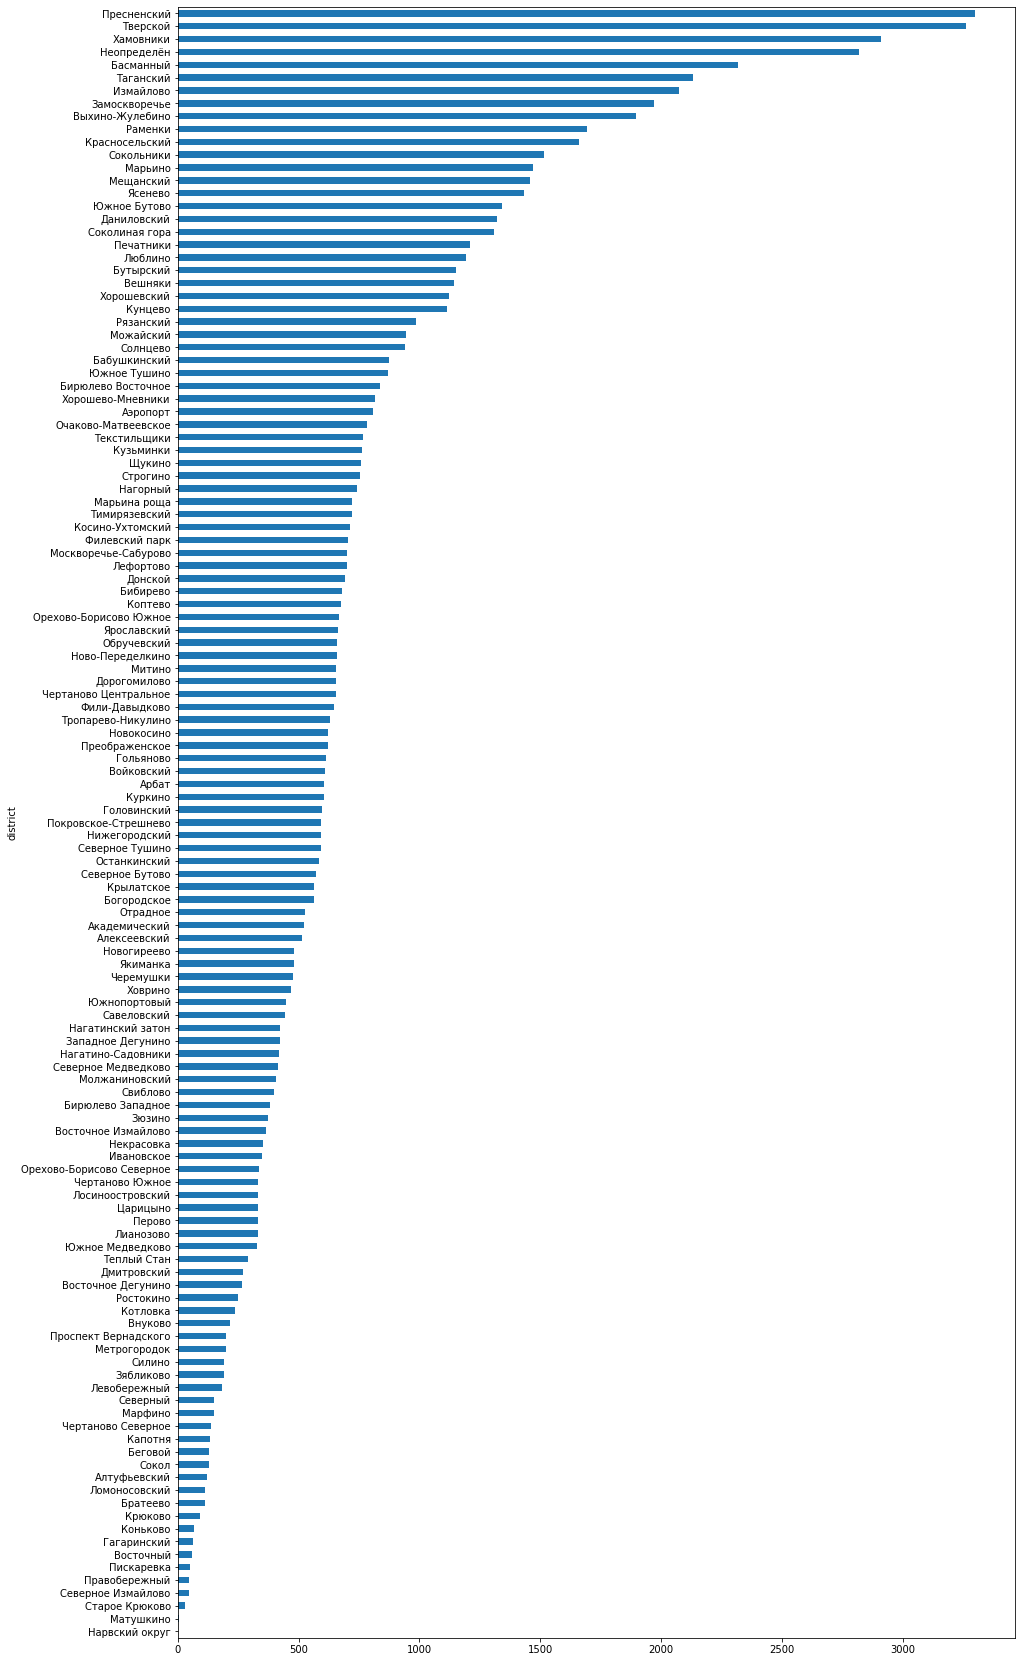

In [ ]:
message_per_district.sort_values().plot(kind="barh", figsize=(15,30))

## Количество сообщений по годам

In [ ]:
message_per_year = frame.groupby(frame['date_clear'].map(lambda x: x.year))['message'].count()

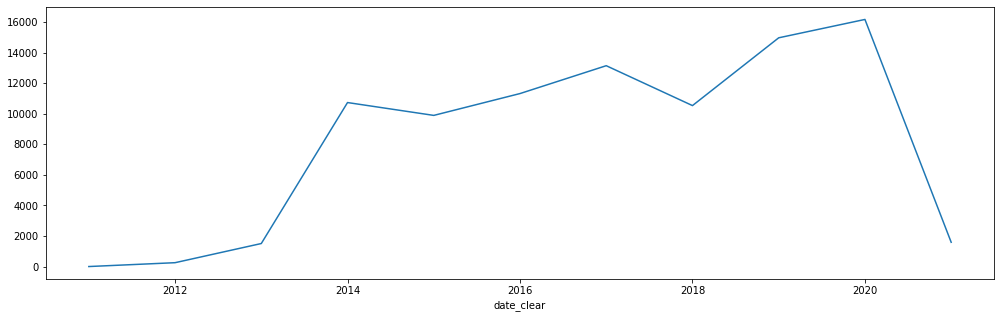

In [ ]:
message_per_year.plot(figsize=(17,5))

## Количество сообщений по темам по годам

In [ ]:
themes_vals_per_year = frame.groupby([frame['date_clear'].map(lambda x: x.year), frame['theme_value']]).count()['message'].unstack()

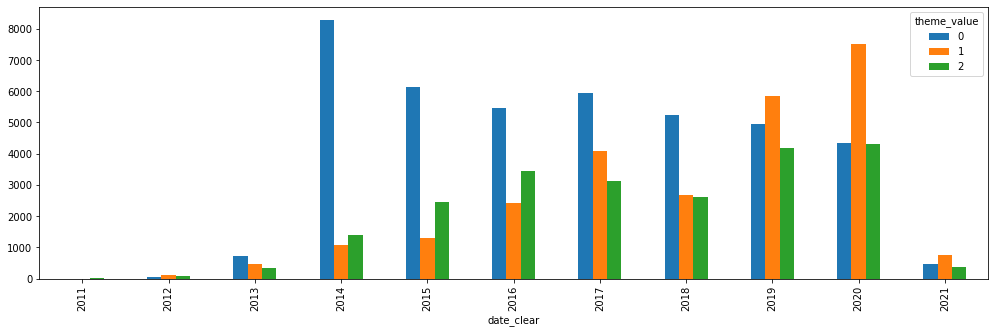

In [ ]:
themes_vals_per_year.plot(kind='bar',
                          figsize=(17,5))

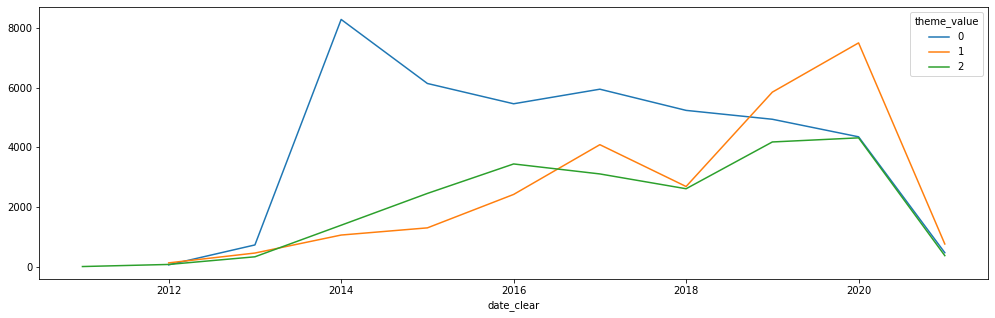

In [ ]:
themes_vals_per_year.plot(figsize=(17,5))

## Основные темы сообщений по годам

In [ ]:
# но это может измениться при следующем запуске
# theme_dict = {0: "Качество окружающей среды",
#               1: "Доля дорожной среды, соответствующей нормативам",
#               2: "Качество городской среды"}

In [ ]:
themes_per_year = frame.groupby([frame['date_clear'].map(lambda x: x.year), frame['theme_value']]).count()['message'].unstack()

In [ ]:
temp = list(map(lambda x: np.argmax(x), themes_per_year.values))

In [ ]:
themes_per_year['theme'] = temp

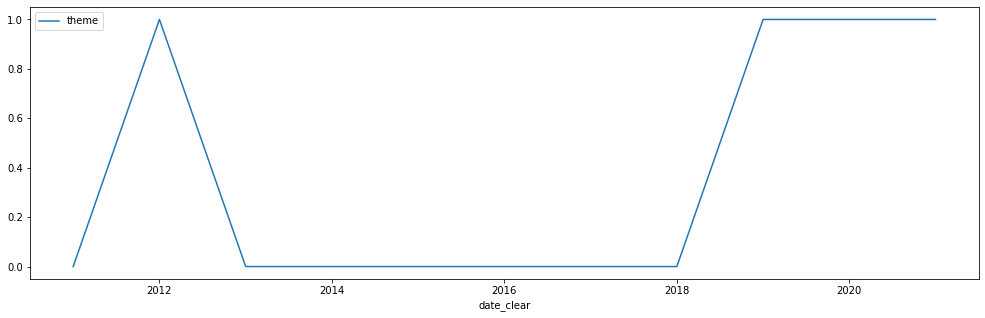

In [ ]:
themes_per_year.plot(y='theme', figsize=(17,5))

## Негативные сообщения по годам (0 - негативные)

In [ ]:
neg_mes_per_year = frame.groupby([frame['date_clear'].map(lambda x: x.year), frame['emo']]).count()['message'].unstack()

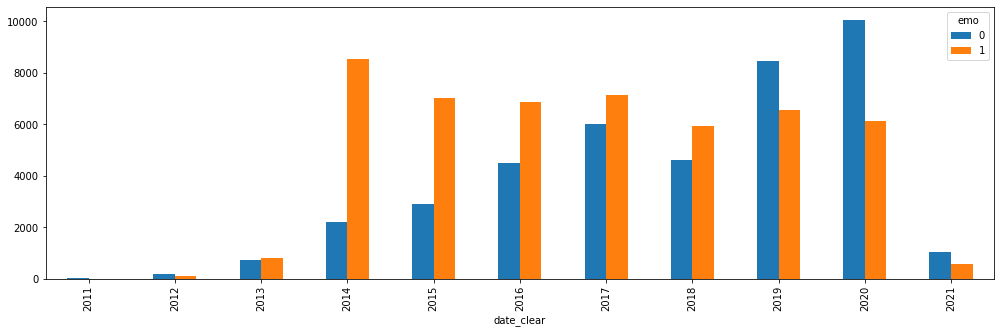

In [ ]:
neg_mes_per_year.plot(kind='bar',
                      figsize=(17,5))

## Негативные сообщения по районам

In [ ]:
neg_mes_per_district = frame.groupby([frame['district'], frame['emo']]).count()['message'].unstack()

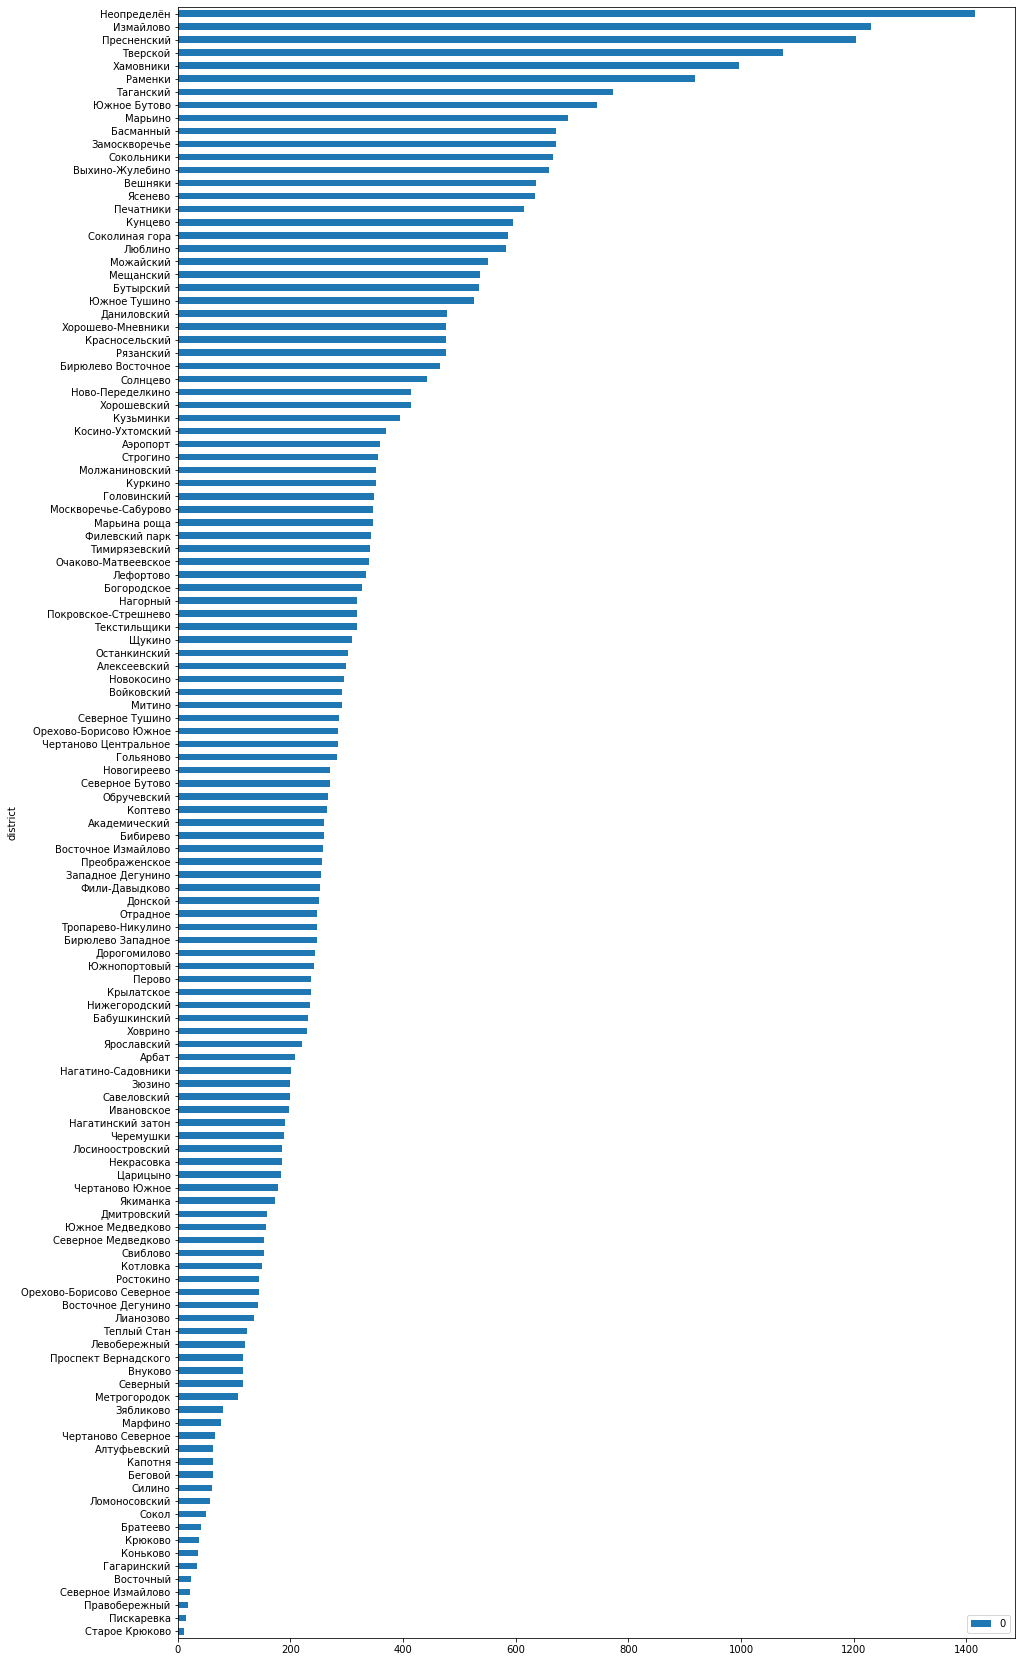

In [ ]:
neg_mes_per_district.sort_values(0).dropna().plot(y=0, kind="barh", figsize=(15,30))

## Geopandas

--2021-05-04 11:49:06--  http://gis-lab.info/data/mos-adm/mo-shape.zip
Resolving gis-lab.info (gis-lab.info)... 116.202.25.4
Connecting to gis-lab.info (gis-lab.info)|116.202.25.4|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://gis-lab.info/data/mos-adm/mo-shape.zip [following]
--2021-05-04 11:49:06--  https://gis-lab.info/data/mos-adm/mo-shape.zip
Connecting to gis-lab.info (gis-lab.info)|116.202.25.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 427645 (418K) [application/zip]
Saving to: ‘mo-shape.zip’

mo-shape.zip        100%[===================>] 417.62K  --.-KB/s    in 0.07s   

2021-05-04 11:49:06 (6.10 MB/s) - ‘mo-shape.zip’ saved [427645/427645]

Archive:  mo-shape.zip
  inflating: mo.cpg                  
  inflating: mo.dbf                  
  inflating: mo.prj                  
  inflating: mo.qml                  
  inflating: mo.qpj                  
  inflating: mo.shp                  
  infla

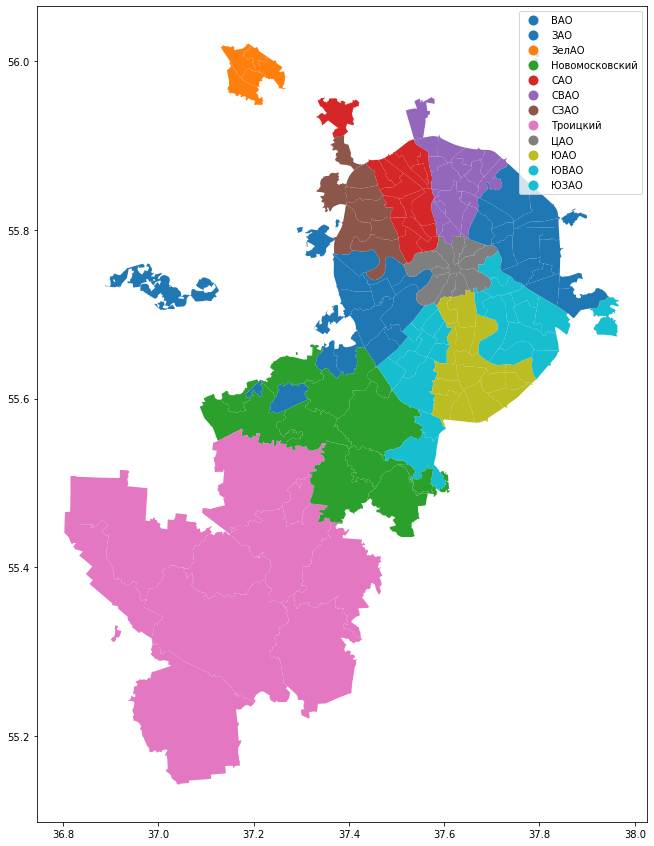

In [ ]:
!wget http://gis-lab.info/data/mos-adm/mo-shape.zip
!unzip mo-shape.zip
!pip install geopandas==0.9.0

import geopandas as gpd
%matplotlib inline
mo_gdf = gpd.read_file('mo.shp')
mo_gdf.plot(column = 'ABBREV_AO', linewidth=0.5, legend=True, figsize=[15,15])

### Количество сообщений по районам

In [ ]:
map_message_per_district = pd.DataFrame(frame.groupby(['district']).count()['message'])
map_message_per_district = map_message_per_district.reset_index()

In [ ]:
map_message_per_district['district_low'] = map_message_per_district['district'].map(lambda x: x.lower().replace('ё', 'е'))

mo_gdf['name_low'] = mo_gdf['NAME'].map(lambda x: x.lower().replace('ё', 'е'))

map_message_per_district_gdf = map_message_per_district.merge(mo_gdf[['geometry', 'name_low']],
                                                              left_on='district_low',
                                                              right_on='name_low',
                                                              how='left')

map_message_per_district_gdf = gpd.GeoDataFrame(map_message_per_district_gdf)

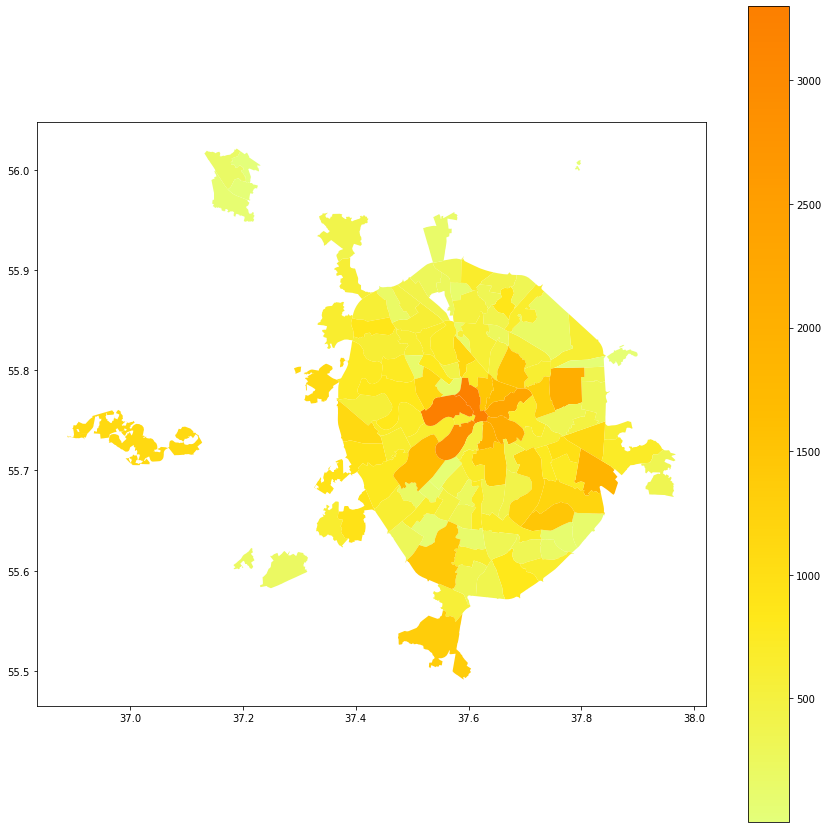

In [ ]:
map_message_per_district_gdf.plot(column = 'message',
                                  linewidth=0.5,
                                  cmap='Wistia',
                                  legend=True,
                                  figsize=[15,15])

### Основные темы по районам

In [ ]:
map_themes_vals_per_district = frame.groupby([frame['district'], frame['theme_value']]).count()['message'].unstack()
temp = list(map(lambda x: np.argmax(x), map_themes_vals_per_district.values))
map_themes_vals_per_district['theme'] = temp

In [ ]:
map_themes_vals_per_district = map_themes_vals_per_district.reset_index()

In [ ]:
map_themes_vals_per_district['district_low'] = map_themes_vals_per_district['district'].map(lambda x: x.lower().replace('ё', 'е'))

mo_gdf['name_low'] = mo_gdf['NAME'].map(lambda x: x.lower().replace('ё', 'е'))

map_themes_vals_per_district_gdf = map_themes_vals_per_district.merge(mo_gdf[['geometry', 'name_low']],
                                                                      left_on='district_low',
                                                                      right_on='name_low',
                                                                      how='left')

map_themes_vals_per_district_gdf = gpd.GeoDataFrame(map_themes_vals_per_district_gdf)

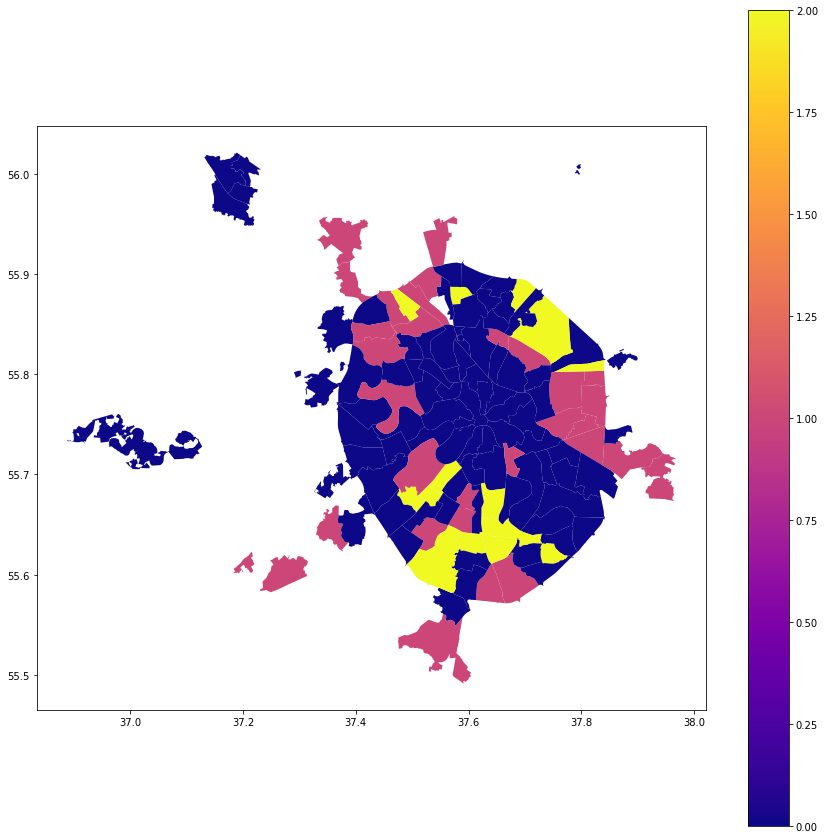

In [ ]:
map_themes_vals_per_district_gdf.plot(column = 'theme',
                                      cmap='plasma',
                                      linewidth=0.5,
                                      legend=True,
                                      figsize=[15,15])

### Негативные сообщения по районам (чем темнее - тем больше негативных сообщений в отношении к обычным)

---



In [ ]:
map_neg_mes_per_district = frame.groupby([frame['district'], frame['emo']]).count()['message'].unstack()
map_neg_mes_per_district['emo'] = map_neg_mes_per_district[1].sub(map_neg_mes_per_district[0])
map_neg_mes_per_district = map_neg_mes_per_district.reset_index()

In [ ]:
map_neg_mes_per_district['district_low'] = map_neg_mes_per_district['district'].map(lambda x: x.lower().replace('ё', 'е'))

mo_gdf['name_low'] = mo_gdf['NAME'].map(lambda x: x.lower().replace('ё', 'е'))

map_neg_mes_per_district_gdf = map_neg_mes_per_district.merge(mo_gdf[['geometry', 'name_low']],
                                                              left_on='district_low',
                                                              right_on='name_low',
                                                              how='left')

map_neg_mes_per_district_gdf = gpd.GeoDataFrame(map_neg_mes_per_district_gdf)

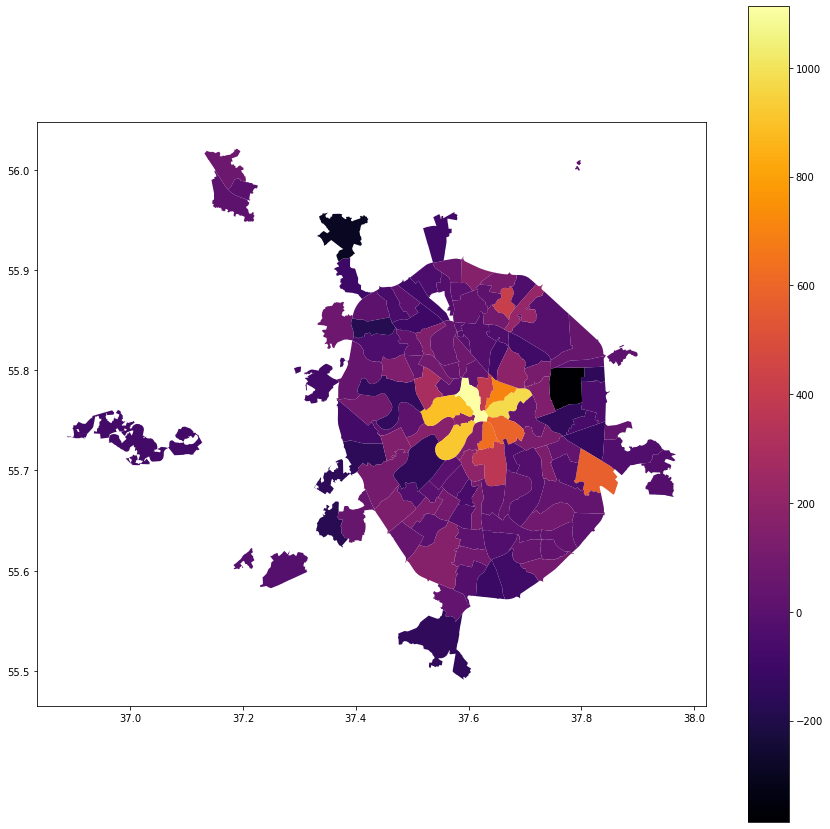

In [ ]:
map_neg_mes_per_district_gdf.plot(column='emo',
                                  cmap='inferno',
                                  linewidth=0.5,
                                  legend=True,
                                  figsize=[15,15])

## Графы

In [ ]:
!wget --no-check-certificate 'https://raw.githubusercontent.com/Daniil193/Simple_KG/0e23cb9b3f3b716728eb11dcf2b0a24f89eba6ef/script_for_graph.py' -O script_for_graph.py
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1IpWUmw_rt-KgLXmLuK5zyJed-OEA-dsu' -O graphs_data.zip

--2021-05-04 11:49:16--  https://raw.githubusercontent.com/Daniil193/Simple_KG/0e23cb9b3f3b716728eb11dcf2b0a24f89eba6ef/script_for_graph.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4325 (4.2K) [text/plain]
Saving to: ‘script_for_graph.py’

script_for_graph.py 100%[===================>]   4.22K  --.-KB/s    in 0s      

2021-05-04 11:49:16 (55.5 MB/s) - ‘script_for_graph.py’ saved [4325/4325]

--2021-05-04 11:49:16--  https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1IpWUmw_rt-KgLXmLuK5zyJed-OEA-dsu
Resolving drive.google.com (drive.google.com)... 108.177.126.139, 108.177.126.102, 108.177.126.101, ...
Connecting to drive.google.com (drive.google.com)|108.177.126.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved

In [ ]:
!pip install nltk stanza

     |████████████████████████████████| 286kB 11.6MB/s 


In [ ]:
import warnings
warnings.filterwarnings("ignore")
%config Completer.use_jedi = False

import pandas as pd
from tqdm import tqdm
import stanza
import json
import pymorphy2
from nltk.tokenize import sent_tokenize

In [ ]:
stanza.download('ru')

2021-05-04 11:49:25 INFO: Downloading default packages for language: ru (Russian)...
2021-05-04 11:51:23 INFO: Finished downloading models and saved to /root/stanza_resources.


In [ ]:
def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def norm_form(morph, word):
    return morph.parse(word)[0].normal_form

### Загрузка препроцессоров

In [ ]:
morph = pymorphy2.MorphAnalyzer(lang="ru")
nlp = stanza.Pipeline(lang='ru', processors='tokenize,pos,lemma,ner,depparse', use_gpu = True)

2021-05-04 11:51:30 INFO: Loading these models for language: ru (Russian):
| Processor | Package   |
-------------------------
| tokenize  | syntagrus |
| pos       | syntagrus |
| lemma     | syntagrus |
| depparse  | syntagrus |
| ner       | wikiner   |

2021-05-04 11:51:30 INFO: Use device: cpu
2021-05-04 11:51:30 INFO: Loading: tokenize
2021-05-04 11:51:30 INFO: Loading: pos
2021-05-04 11:51:31 INFO: Loading: lemma
2021-05-04 11:51:31 INFO: Loading: depparse
2021-05-04 11:51:31 INFO: Loading: ner
2021-05-04 11:51:32 INFO: Done loading processors!


### Clearing & Filtering data

In [ ]:
df = frame[['message', 'theme_value']]

df["lens"] = df["message"].apply(lambda x: len(str(x)))

df_filtered = df[df["lens"] > 50]

df_0 = df_filtered[df_filtered["theme_value"]==0]
df_1 = df_filtered[df_filtered["theme_value"]==1]
df_2 = df_filtered[df_filtered["theme_value"]==2]

### Tokenizing

In [ ]:
full_corpus = df_0["message"].values

In [ ]:
try:
    sentences = [sent for corp in full_corpus for sent in sent_tokenize(corp, language="russian")]
except:
    import nltk
    nltk.download('punkt')
    sentences = [sent for corp in full_corpus for sent in sent_tokenize(corp, language="russian")]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
long_sents = [i for i in sentences if len(i) > 20]

### Get Triplets

In [ ]:
%%time
triplets = []
for s in tqdm(long_sents):
    doc = nlp(s)
    for sent in doc.sentences:
            entities = [ent.text for ent in sent.ents]
            res_d = dict()
            temp_d = dict()
            for word in sent.words:
                temp_d[word.text] = {"head": sent.words[word.head-1].text, "dep": word.deprel, "id": word.id}
            for k in temp_d.keys():
                nmod_1 = ""
                nmod_2 = ""
                if (temp_d[k]["dep"] in ["nsubj", "nsubj:pass"]) & (k in entities):
                    res_d[k] = {"head": temp_d[k]["head"]}
                    
                    for k_0 in temp_d.keys():
                        if (temp_d[k_0]["dep"] in ["obj", "obl"]) &\
                           (temp_d[k_0]["head"] == res_d[k]["head"]) &\
                            (temp_d[k_0]["id"] > temp_d[res_d[k]["head"]]["id"]):
                            res_d[k]["obj"] = k_0
                            break
                    
                    for k_1 in temp_d.keys():
                        if (temp_d[k_1]["head"] == res_d[k]["head"]) & (k_1 == "не"):
                            res_d[k]["head"] = "не "+res_d[k]["head"]
                    
                    if "obj" in res_d[k].keys():
                        for k_4 in temp_d.keys():
                            if (temp_d[k_4]["dep"] =="nmod") &\
                               (temp_d[k_4]["head"] == res_d[k]["obj"]):
                                nmod_1 = k_4
                                break
                                
                        for k_5 in temp_d.keys():
                            if (temp_d[k_5]["dep"] =="nummod") &\
                               (temp_d[k_5]["head"] == nmod_1):
                                nmod_2 = k_5
                                break
                        res_d[k]["obj"] = res_d[k]["obj"]+" "+nmod_2+" "+nmod_1

            if len(res_d) > 0:
                triplets.append([s, res_d])

 25%|██▌       | 8989/35368 [1:04:31<2:12:44,  3.31it/s]

In [ ]:
clear_text = lambda x: "".join(i if (i.isdigit()) | (i.isalpha()) | (i in [" "]) else " " for i in x )

clear_triplets = dict()
for tr in triplets:
    for k in tr[1].keys():
        if "obj" in tr[1][k].keys():
            ## clear_text убрать, если не нужна очистка предложений
            clear_triplets[clear_text(tr[0])] =  [k, tr[1][k]['head'], tr[1][k]['obj']]

In [ ]:
for_df = []
for k in clear_triplets.keys():
    for_df.append([k]+clear_triplets[k])

### Create DF for prepare

In [ ]:
df_triplets = pd.DataFrame(for_df, columns=["full_sent", "subject", "verb", "object"])

df_triplets["subj_n_f"] = df_triplets["subject"].apply(lambda x: norm_form(morph, x))
df_triplets["obj_n_f"] = df_triplets["object"].apply(lambda x: norm_form(morph, x))

df_filtered = df_triplets[(~df_triplets["subj_n_f"].isin(stopwords)) &\
                          (~df_triplets["obj_n_f"].isin(stopwords))].sort_values(by="obj_n_f", ascending=False, ignore_index=True)

### Split data on chunks

In [ ]:
groups = list(chunks(df_filtered["obj_n_f"].unique(), 100))
gr_num = 0
df_for_draw = df_filtered[df_filtered["obj_n_f"].isin(groups[gr_num])]
nodes = pd.unique(df_for_draw[["subj_n_f", "obj_n_f"]].values.ravel("K"))

### Get edges & edges info

In [ ]:
df_d_d = df_for_draw.drop_duplicates(subset=["subj_n_f", "obj_n_f", "verb"])[["subj_n_f", "obj_n_f", "verb", "full_sent"]]

info_dict = dict()
label_dict = dict()
for cc, raw in enumerate(df_d_d.values):
    info_dict[(raw[0], raw[1])] = {f"sent_{cc}": raw[3]}
    label_dict[(raw[0], raw[1])] = raw[2]

word_num = dict()
for c, word in enumerate(nodes):
    word_num[word] = c+1

### Draw Graph

In [ ]:
import script_for_graph
import importlib
importlib.reload(script_for_graph)
from script_for_graph import header_text, tail_text

header_text += """\nvar nodes = new vis.DataSet([\n"""
for w in nodes:
    header_text += "{"
    header_text += f"""         id: {word_num[w]}, 
                                label: "{w}"\n"""
    header_text += "},"
header_text += "   ]);\n"

header_text += """var edges = new vis.DataSet(["""
for k in info_dict.keys():
    header_text += "{"
    header_text += f"""       from: {word_num[k[0]]}, 
                    to: {word_num[k[1]]}, 
                    arrows: "to",
                    label: "{label_dict[k]}",
                    info: {info_dict[k]}\n"""
    header_text +="},"
header_text += "   ]);\n"

full_text = ""
full_text += header_text
full_text += tail_text

with open(f"Graph_for_group_{gr_num}.html", "w", encoding="utf-8") as f: 
    f.write(full_text)